## Dataset for very deep learning
Data [here:](https://gitlab.com/sarmaps/sar-ship-dataset)

Article [here:](https://sci-hub.ren/10.1109/igarss.2016.7729017)

In [206]:
import os

import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split
from collections import Counter
from os.path import join
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pylab
plt.rcParams['figure.figsize'] = 10, 10
%matplotlib inline

In [207]:
# Define path to the data
PATH = r'C:\Users\arman\Documents\GitHub\sar_ship_detect'
#data_path = join(os. getcwd(), '..','data', 'Iceberg-classifier-challenge')
data_path = join(PATH, 'data', 'very_deep_learn_data', 'json')

In [208]:
os.listdir(data_path)

['false_positives.json', 'ship_positives.json', 'true_negatives.json']

### DATA DESCRIPTION
A SAR dataset has been created using 22 Sentinel-1 (Extra
Wide Swath) and 3 RADARSAT-2 (Scan-SAR Narrow) acquisition with a total of 42 dual and 4 single polarized, radiometrically calibrated images. The dataset covers approximately 80% of the South African Exclusive Economic Zone (EEZ) with multiple acquisitions over a number of harbours (high ship densities). For this experiment, the dataset was analysed and split into three classes of `21 × 21` sub-images, containing **ships** (`positives`), **ship-like areas** (`false positives`) and **ocean areas** (`negatives`). The usefulness of splitting the samples up into three classes is that it now allows for a more descriptive analysis of how various methods deal with `ship lookalikes` and open ocean areas. The `1596 positive examples` were identified using expert analysis with each ship having an associated ground truth image not used in this experiment. The false positive sub-images were generated by selecting areas that did not contain ships but were incorrectly highlighted by a `low-threshold cell-averaging constant false alarm rate` (CA-CFAR). This lowthreshold approach was done to generate as many samples as possible for future experiments. Of the approximate 500 000 false positive sub-images extracted across the 46 images, `3192 false positive` images were selected at random. This is twice as many as the positive examples and represents the distribution of false positives to positives that would be encountered with careful prescreening threshold design and selection. Finally, `1596 sub-images that did not contain either a ship or false positive` were selected as negative ocean samples. Depending on the selected prescreening method, the negative samples will often not be presented to the ship discrimination classifier. They are provided here, however, to train the classifier to handle negative samples. No additional feature extraction was performed on the 9588 sub-images resulting in input feature set of 21x21 normalized RCS pixel values per image․

In [209]:
#Load the data.
false_positives = pd.read_json(join(data_path, 'false_positives.json'))
ship_positives = pd.read_json(join(data_path, 'ship_positives.json'))
true_negatives = pd.read_json(join(data_path, 'true_negatives.json'))

In [210]:
print('true_positives: ',ship_positives.shape)
print('false_positives:',false_positives.shape) # not corresponding to the data sescribtion, should be checked out
print('true_negatives: ',true_negatives.shape)

true_positives:  (1, 1596)
false_positives: (1, 6384)
true_negatives:  (1, 1596)


### Extract the beccessary data from the datasets

In [211]:
def data_extract(data_frame, dict_key):
    """Extract data from json file and 
    transform it as ndarray"""
    #dict_key: should be text
    
    list_of_bands = []
    for i in range(data_frame.shape[1]):
        single_arr = data_frame[i][0][dict_key]
        
        # we need to recover the incidence angle as a band image
        if dict_key == 'incidenceangle':
            band = np.full((21, 21), single_arr)
        else:
            band = single_arr
            
        list_of_bands.append(band)

    return np.array(list_of_bands)

### Recover the incidence angle as a band

In [212]:
# get true positive data
ship_positive_data = data_extract(ship_positives, 'windowfu')
#ship_positive_target = data_extract(ship_positives, 'validais')
ship_positive_angle = data_extract(ship_positives, 'incidenceangle')
# define ship target cass as "2"
ship_positive_target = np.full(ship_positives.shape[1], 2)


In [213]:
# get false positive data
false_positives_data = data_extract(false_positives, 'windowfu')
false_positives_angle = data_extract(false_positives, 'incidenceangle')
false_positives_target = data_extract(false_positives, 'thresh')

In [214]:
# get true negative data
true_negatives_data = data_extract(true_negatives, 'windowfu')
true_negatives_angle = data_extract(true_negatives, 'incidenceangle')
true_negatives_target = data_extract(true_negatives, 'thresh')

In [215]:
radar_data = np.concatenate([ship_positive_data, false_positives_data, true_negatives_data])
angle_data = np.concatenate([ship_positive_angle, false_positives_angle, true_negatives_angle])
target = np.concatenate([ship_positive_target, false_positives_target, true_negatives_target])

In [216]:
pd.DataFrame([dict(Counter(target))])

,2,1,0
0,1596,6384,1596


In [217]:
data = np.concatenate([radar_data[:, :, :, np.newaxis], angle_data[:, :, :, np.newaxis]], axis=-1)

In [218]:
print(data.shape)
target.shape

(9576, 21, 21, 2)


(9576,)

### Data visualization

Text(0.5, 1.0, 'random noise')

<Figure size 432x288 with 0 Axes>

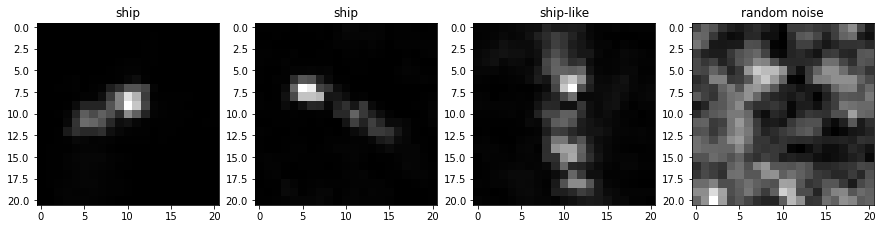

In [219]:
# visualize image samples

plt.figure()

#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(1,4, figsize=(15, 15)) 

# use the created array to output your multiple images. In this case I have stacked 4 images vertically
axarr[0].imshow(ship_positive_data[1200,:,:], cmap="gray")
axarr[0].set_title('ship')
axarr[1].imshow(ship_positive_data[14,:,:], cmap="gray")  
axarr[1].set_title('ship')
axarr[2].imshow(false_positives_data[665,:,:], cmap="gray")
axarr[2].set_title('ship-like')
axarr[3].imshow(true_negatives_data[121,:,:], cmap="gray") 
axarr[3].set_title('random noise')

In [237]:
#Import Keras.
from matplotlib import pyplot
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, Activation, Conv1D, MaxPooling1D
from keras.layers import GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.models import Model
from keras import initializers
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.metrics import binary_accuracy

### Model architecture modification

CNN model is modified the way to handle with 2 input bands only and saller image size

In [264]:
#original model
#define our model
def getModel():
    #Building the model
    gmodel=Sequential()
    #Conv Layer 1
    #gmodel.add(Conv2D(64, kernel_size=(3, 3),activation='relu', input_shape=(75, 75, 3)))
    gmodel.add(Conv1D(64, kernel_size= 3,activation='relu', batch_input_shape =(21, 21, 2)))
    gmodel.add(MaxPooling1D(pool_size= 3, strides=1))
    gmodel.add(Dropout(0.2))

    #Conv Layer 2
    gmodel.add(Conv1D(128, kernel_size=3, activation='relu' ))
    gmodel.add(MaxPooling1D(pool_size= 2, strides=1))
    gmodel.add(Dropout(0.2))

    #Conv Layer 3
    gmodel.add(Conv1D(128, kernel_size=3, activation='relu'))
    gmodel.add(MaxPooling1D(pool_size= 2, strides=1))
    gmodel.add(Dropout(0.2))

    #Conv Layer 4
    gmodel.add(Conv1D(64, kernel_size= 3, activation='relu'))
    gmodel.add(MaxPooling1D(pool_size= 2, strides=1))
    gmodel.add(Dropout(0.2))

    #Flatten the data for upcoming dense layers
    gmodel.add(Flatten())

    #Dense Layers
    gmodel.add(Dense(512))
    gmodel.add(Activation('relu'))
    gmodel.add(Dropout(0.2))

    #Dense Layer 2
    gmodel.add(Dense(256))
    gmodel.add(Activation('relu'))
    gmodel.add(Dropout(0.2))

    #Sigmoid Layer
    gmodel.add(Dense(1))
    gmodel.add(Activation('sigmoid'))
    
    # compile model
    #mypotim = SGD(lr=0.01, momentum=0.9)
    mypotim=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    gmodel.compile(loss='categorical_crossentropy',                             #binary_crossentropy
                  optimizer=mypotim,
                  metrics=['accuracy'])                                         # f1_score and g-mean to be implemented
    gmodel.summary()
    return gmodel


def get_callbacks(filepath, patience=2):
    es = EarlyStopping('val_loss', patience=patience, mode="min")
    msave = ModelCheckpoint(filepath, save_best_only=True)
    return [es, msave]

#file_path = ".model_weights.hdf5"
#file_path = ".model_weights_inc_angle_as_band.hdf5"
file_path = ".model_weights_very_deep_learn_ds.hdf5"
callbacks = get_callbacks(filepath=file_path, patience=5)

### Data split

In [259]:
# Define the data split strategy
def data_split(data, target, train_size, test_size): 
    ''' Train-validation-test split'''

    # split data to get the initial training test split
    X_train, X_test, y_train, y_test = train_test_split(data, target, random_state=1, 
                                                train_size=train_size, stratify = target)
    
    # split data to get train validation split
    X_train_cv, X_valid, y_train_cv, y_valid = train_test_split( X_train, y_train, random_state=1,
                                                test_size = valid_size, stratify = y_train) 
    
    return  X_train_cv, X_valid, X_test, y_train_cv, y_valid, y_test

# define split parameters
train_size = 0.70
valid_size = 0.20

X_train_cv, X_valid, X_test, y_train_cv, y_valid, y_test = data_split(data, target, train_size, valid_size )
print(f'data split: \nTrain: \t   {X_train_cv.shape[0]} \nValidation: {X_valid.shape[0]} \nTest: \t    {X_test.shape[0]}')

data split: 
Train: 	   5362 
Validation: 1341 
Test: 	    2873


In [265]:
#Without denoising, core features.
gmodel=getModel()
gmodel.fit(X_train_cv, y_train_cv,
          batch_size=24,
          epochs=50,
          verbose=1,
          validation_data=(X_valid, y_valid),
          callbacks=callbacks)

ValueError: Input 0 is incompatible with layer conv1d_19: expected ndim=3, found ndim=4